NDB Model

**Sources**:
- [Illustrating the Performance of the NBD as a Benchmark Model for Customer-Base Analysis](http://www.brucehardie.com/notes/005/)

In [39]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import beta, gamma, gammaln, factorial, hyp2f1
from scipy.stats import chisquare, chi2

import matplotlib.pyplot as plt
import matplotlib_inline
from IPython.display import display_markdown

from utils import CDNOW, bic

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [40]:
data = (
    CDNOW(master=False, calib_p=273)
    .rfm_summary()
    .select('P1X', 't_x', 'T')
)

# x: 'repeat_trans' = “repeat frequency”, number of repeat transactions made by a customer in a specified time period.
# t_x: 'last_purch' (in weeks) = Time of last calibration period repeat purchase 
# T: 'T' (in weeks) = length of time over which we have had an opportunity to observe any repeat purchasing behavior. 
# 'first_purch' = Time of first purchase (in weeks)
repeat_trans, last_purch, T = np.hsplit(data.collect().to_numpy(), 3)
num_customers = len(repeat_trans)

In [41]:
# NBD Model - timing-model equivalent of the basic NBD model
def nbd_timing_params(x, T):
    def log_likelihood(params):
        r, alpha = params
        return -np.sum(gammaln(r+x)-gammaln(r)+r*np.log(alpha)-(r+x)*np.log(alpha+T))
    return minimize(log_likelihood, x0=[0.1,0.1], bounds=[(1e-6, np.inf), (1e-6, np.inf)])

def nbd_pmf(x, t, r, alpha):
    # P(X(T)=x)
    # np.exp(gammaln(r+x)-gammaln(r))/factorial(x) * (alpha/(alpha+T))**r * (T/(alpha+T))**x
    return gamma(r + x)/(gamma(r)*factorial(x)) * (alpha/(alpha+t))**r * (t/(alpha+t))**x

# NBD Model - standard counting form
def nbd_params(x, T):
    def log_likelihood(params):
        r, alpha = params
        # P(X(T)=x)
        pmf = nbd_pmf(x, T, r, alpha)
        return -np.sum(np.log(pmf))
    return minimize(log_likelihood, x0=[0.1,0.1], bounds=[(1e-6, np.inf), (1e-6, np.inf)])

# BG/NBD Model
def bgnbd_params(x, t_x, T):
    def log_likelihood(params):
        r, alpha, a, b = params
        likelihood_function = (
            beta(a,b+x)/beta(a,b) * 
            (gamma(r+x)*alpha**r)/(gamma(r)*(alpha+T)**(r+x))
        )
        likelihood_function += (
            np.where(x > 0,
                beta(a+1, b+x-1)/beta(a,b) *
                (gamma(r+x)*alpha**r)/(gamma(r)*(alpha+t_x)**(r+x)),
                0)
        )
        return -np.sum(np.log(likelihood_function))
    
    bnds = [(1e-6, np.inf) for _ in range(4)]
    guess = [0.01 for _ in range(4)]
    return minimize(log_likelihood, x0=guess, bounds=bnds)

# expected number of purchases in a time period of length t
def bgnbd_E_X_t(t, r, alpha, a, b):
    return (a+b-1)/(a-1) * (1 - (alpha/(alpha+t))**r * hyp2f1(r, b, a+b-1, t/(alpha+t)))

# probability of observing x purchases in a time period of length t
def bgnbd_pmf(f_x, t, r, alpha, a, b):
    A = np.cumsum(
        gamma(r+f_x[:-1])/(gamma(r)*factorial(f_x[:-1])) *
        (t/(alpha+t))**f_x[:-1], axis=0
    )
    pmf = (
        beta(a,b+f_x)/beta(a,b) * 
        gamma(r+f_x)/(gamma(r)*factorial(f_x)) * 
        (alpha/(alpha+t))**r * 
        (t/(alpha+t))**f_x
    )
    pmf[1:] += (
        beta(a+1,b+f_x[1:]-1)/beta(a,b) *
        (1 - (alpha/(alpha+t))**r * A)        
    )
    return pmf

# Pareto/NBD Model
def paretonbd_params(x, t_x, T):
    
    def log_likelihood(params):
        r, alpha, s, beta = params
        
        maxab = np.max((alpha, beta))
        absab = np.abs(alpha - beta)
        param2 = s + 1
        if alpha < beta:
            param2 = r + x
            
        part1 = (alpha**r * beta**s / gamma(r)) * gamma(r+x)
        part2 = 1/((alpha+T)**(r+x) * (beta+T)**s)

        if absab == 0:
            F1 = 1/((maxab+t_x)**(r+s+x))
            F2 = 1/((maxab+T)**(r+s+x))
        else:
            F1 = hyp2f1(r+s+x, param2, r+s+x+1, absab/(maxab+t_x)) / ((maxab+t_x)**(r+s+x))
            F2 = hyp2f1(r+s+x, param2, r+s+x+1, absab/(maxab+T)) / ((maxab+T)**(r+s+x))        
        
        return -np.sum(np.log(part1*(part2+(s/(r+s+x))*(F1-F2))))
    
    bnds = [(1e-6, 20) for _ in range(4)]
    guess = [0.01 for _ in range(4)]
    return minimize(log_likelihood, x0=guess, bounds=bnds)

# distribution of the number of transactions in the interval (0, t] for a randomly-chosen individual
def paretonbd_pmf(f_x, t, r, alpha, s, beta_param):
    maxab = np.max((alpha, beta_param))
    absab = np.abs(alpha - beta_param)
    param2 = s + 1
    if alpha < beta_param:
        param2 = r + f_x    
    B2i = np.cumsum(
        gamma(r+s+f_x)/gamma(r+s) * t**f_x / factorial(f_x) *
        hyp2f1(r+s+f_x, param2, r+s+f_x+1, absab/(maxab+t)) / 
        (maxab+t)**(r+s+f_x),
        axis=0
    )
    pmf = (
        gamma(r+f_x)/(gamma(r)*factorial(f_x)) *
        (alpha/(alpha+t))**r * 
        (t/(alpha+t))**f_x *
        (beta_param/(beta_param+t))**s +
        alpha**r * beta_param**s *
        beta(r+f_x,s+1)/beta(r,s) *
        (hyp2f1(r+s, param2, r+s+f_x+1, absab/maxab) / maxab**(r+s) - B2i)
    )
    return pmf

In [42]:
res = nbd_timing_params(repeat_trans, T)
r_nbd, alpha_nbd = res.x
ll = res.fun

display_markdown(f'''**NBD - Timing-Model Equivalent:**

Parameter Estimates:
- $r$ = {r_nbd:0.4f}
- $\\alpha$ = {alpha_nbd:0.4f}

Log-Likelihood = {-ll:0.4f}

BIC = {bic(2, num_customers, ll):.1f}''', raw=True)

res = nbd_params(repeat_trans, T)
r, alpha = res.x
ll = res.fun

display_markdown(f'''**NBD - Standard Counting Method:**

Parameter Estimates:
- $r$ = {r:0.4f}
- $\\alpha$ = {alpha:0.4f}

Log-Likelihood = {-ll:0.4f}

BIC = {bic(2, num_customers, ll):.1f}''', raw=True)

res = bgnbd_params(repeat_trans, last_purch, T)
r_bgnbd, alpha_bgnbd, a_bgnbd, b_bgnbd = res.x
ll = res.fun

display_markdown(f'''**BG/NBD:**

Parameter Estimates:
- $r$ = {r_bgnbd:0.4f}
- $\\alpha$ = {alpha_bgnbd:0.4f}
- $a$ = {a_bgnbd:0.4f}
- $b$ = {b_bgnbd:0.4f}

Log-Likelihood = {-ll:0.4f}

BIC = {bic(4, num_customers, ll):.1f}''', raw=True)

res = paretonbd_params(repeat_trans, last_purch, T)
r_pareto, alpha_pareto, s, beta_param = res.x
ll = res.fun

display_markdown(f'''**Pareto/NBD:**

Parameter Estimates:
- $r$ = {r_pareto:0.4f}
- $\\alpha$ = {alpha_pareto:0.4f}
- $s$ = {s:0.4f}
- $\\beta$ = {beta_param:0.4f}

Log-Likelihood = {-ll:0.4f}

BIC = {bic(4, num_customers, ll):.1f}''', raw=True)

**NBD - Timing-Model Equivalent:**

Parameter Estimates:
- $r$ = 0.3848
- $\alpha$ = 12.0718

Log-Likelihood = -9763.6576

BIC = 19542.8

**NBD - Standard Counting Method:**

Parameter Estimates:
- $r$ = 0.3848
- $\alpha$ = 12.0718

Log-Likelihood = -3193.0587

BIC = 6401.6

**BG/NBD:**

Parameter Estimates:
- $r$ = 0.2426
- $\alpha$ = 4.4136
- $a$ = 0.7929
- $b$ = 2.4258

Log-Likelihood = -9582.4292

BIC = 19195.9

**Pareto/NBD:**

Parameter Estimates:
- $r$ = 0.5533
- $\alpha$ = 10.5781
- $s$ = 0.6064
- $\beta$ = 11.6726

Log-Likelihood = -9594.9762

BIC = 19221.0

Predicted Distribution of Transactions

In [43]:
def nbd_predict_trans_dist(f_x, n_s, T, r, alpha):
    '''
    Parameters:
    f_x:    frequency of repeat transactions (right-censored)
    n_s:    the number of customers who made their first purchase on day s
    T:      the number of days (in weeks) during which repeat transactions could have occurred in the calibration period, 
            it follows that the “time of first purchase” is simply: calibration week - T.
    r, alpha: NBD model parameters
    '''
    pmf = nbd_pmf(f_x, T, r, alpha)
    pmf[-1] = 1 - np.sum(pmf[:-1], axis=0)
    return np.dot(pmf, n_s)

def bgnbd_predict_trans_dist(f_x, n_s, T, r, alpha, a, b):
    pmf = bgnbd_pmf(f_x, T, r, alpha, a, b)
    pmf[-1] = 1 - np.sum(pmf[:-1], axis=0)
    return np.dot(pmf, n_s)

def paretonbd_redict_trans_dist(f_x, n_s, t, r, alpha, s, beta_param):
    pmf = paretonbd_pmf(f_x, t, r, alpha, s, beta_param)
    pmf[-1] = 1 - np.sum(pmf[:-1], axis=0)
    return np.dot(pmf, n_s)

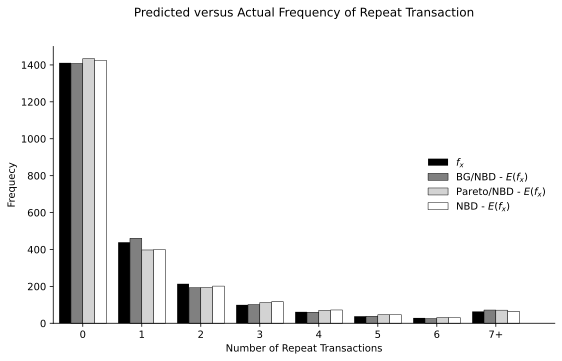

In [65]:
num_repeats, repeat_freq = np.unique(repeat_trans, return_counts=True)

# right-censored distribution in which counts greater than 7 are collapsed into a 7+ bin
num_repeats_censored = num_repeats[:8]
repeat_freq_censored = repeat_freq[:8]
repeat_freq_censored[-1] = np.sum(repeat_freq) - np.sum(repeat_freq[:7])

# n_s is the number of customers who made their first purchase on day s
# T_unique is the unique t - s/7 weeks within which to make repeat purchases
T_unique, n_s = np.unique(T, return_counts=True)

nbd_E_f_x = nbd_predict_trans_dist(num_repeats_censored.reshape(-1,1), n_s, T_unique, r_nbd, alpha_nbd)
bgnbd_E_f_x = bgnbd_predict_trans_dist(num_repeats_censored.reshape(-1,1), n_s, T_unique, r_bgnbd, alpha_bgnbd, a_bgnbd, b_bgnbd)
paretonbd_E_f_x = paretonbd_redict_trans_dist(num_repeats_censored.reshape(-1,1), n_s, T_unique, r_pareto, alpha_pareto, s, beta_param)

bar_width = 0.2
plt.figure(figsize=(9,5), dpi=100)
plt.bar(num_repeats_censored - bar_width*1.5, repeat_freq_censored, width=bar_width, label='$f_x$', color='black')
plt.bar(num_repeats_censored - bar_width/2, bgnbd_E_f_x, width=bar_width, label='BG/NBD - $E(f_x)$', color='grey', edgecolor='black', linewidth=0.5)
plt.bar(num_repeats_censored + bar_width/2, paretonbd_E_f_x, width=bar_width, label='Pareto/NBD - $E(f_x)$', color='lightgrey', edgecolor='black', linewidth=0.5)
plt.bar(num_repeats_censored + bar_width*1.5, nbd_E_f_x, width=bar_width, label='NBD - $E(f_x)$', color='white', edgecolor='black', linewidth=0.5)
plt.xlabel("Number of Repeat Transactions")
plt.ylabel("Frequecy")
plt.title('Predicted versus Actual Frequency of Repeat Transaction', pad=30)
plt.xticks(num_repeats_censored, [0,1,2,3,4,5,6,'7+'])
plt.ylim(0, 1500)
plt.xlim(0-bar_width*2.5, 8)
plt.legend(loc=7, frameon=False);